In [1]:
import pandas as pd
import numpy as np
import spiro.data_preprocessing
from spiro.models import *
from spiro.learners import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
import random
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from tqdm import tqdm

# Setting the seed for reproducibility

np.random.seed(0)
random.seed(0)

In [2]:
import warnings
from sklearn.exceptions import DataConversionWarning

warnings.filterwarnings(action="ignore", category=DataConversionWarning)

In [3]:
data = pd.read_csv("../data/feature_30_joint_51.csv")
data2 = pd.DataFrame(np.load("../data/Final_features_3k5k_order5_53.npy",allow_pickle=True))

In [4]:
data= data[~data.iloc[:,0].isin([21,48])].reset_index(drop=True)

In [5]:
data.drop("Unnamed: 0",axis=1,inplace=True)

In [6]:
remove = ['P1', 'P11', 'P22', 'P22', 'P25', 'P37', 'P4', 'P47', 'P48', 'P49', 'P54', 'P56', 'P59','P16', 'P24', 'P68', 'P72','P74','P75','P30','P67']
data2 = data2[~data2.iloc[:,0].isin(remove)]
data2.shape

(51, 713)

In [7]:
X= pd.DataFrame(data,dtype="float")

In [8]:
pid= data2.iloc[:,0].values

In [9]:
X = MinMaxScaler().fit_transform(X)
Y = data2.iloc[:,-2:].astype("float")
Y = np.array(Y)

In [10]:
def train_pool_split(X, Y, train_idx, test_idx):
    pool_idx = [i for i in range(0, X.shape[0]) if i not in train_idx + test_idx]
    X_train, X_test, X_pool = X[train_idx], X[test_idx], X[pool_idx]
    Y_train, Y_test, Y_pool = Y[train_idx], Y[test_idx], Y[pool_idx]
    print("Shape of X_train = {} and Y_train = {}".format(X_train.shape, Y_train.shape))
    print("Shape of X_test = {} and Y_test = {}".format(X_test.shape, Y_test.shape))
    print("Shape of X_pool = {} and Y_pool = {}".format(X_pool.shape, Y_pool.shape))
    return X_train, X_test, X_pool, Y_train, Y_test, Y_pool


In [11]:
train_idx, test_idx= [1, 40, 38, 15, 45, 10, 19, 35], [0, 42, 30, 6, 17, 8, 33, 44, 11, 36]


In [12]:
X_train, X_test, X_pool, Y_train, Y_test, Y_pool = train_pool_split(
X, Y, train_idx, test_idx
)

Shape of X_train = (8, 30) and Y_train = (8, 2)
Shape of X_test = (10, 30) and Y_test = (10, 2)
Shape of X_pool = (33, 30) and Y_pool = (33, 2)


In [13]:
scores = {}
for i in ["std_dev", "rank", "random", "round_robin"]:
    scores["FVC_" + i] = []
    scores["FEV1_" + i] = []

In [14]:
def multi_al_loop(model, strategy):
    learner = MultiLearner(model, strategy, X_pool, [Y_pool[:, 0], Y_pool[:, 1]])
    learner.fit(X_train, [Y_train[:, 0], Y_train[:, 1]])
    score, pred = learner.score(X_test, Y_test, "mape",print_score=True)
    scores["FVC_" + strategy].append(score[1])
    scores["FEV1_" + strategy].append(score[0])
    for i in range(33):
        q, _ = learner.query([0.3, 0.7],print_query_idx=False)
        learner.teach(q)
        score, pred = learner.score(X_test, Y_test, "mape")
        scores["FVC_" + strategy].append(score[1])
        scores["FEV1_" + strategy].append(score[0])

In [15]:
rf1 = RandomForestRegressor(random_state=0) #for FEV1
rf2 = RandomForestRegressor(random_state=108) #for FVC

In [16]:
model1 = SklearnEnsemble(rf1)
model2 = SklearnEnsemble(rf2)

In [17]:
multi_al_loop([model1, model2], "std_dev")

Fitting the model on initial train data


Score for the multiple tasks are [5.931653764086877, 5.321598923182042]


In [18]:
np.random.seed(0)
random.seed(0)
final_random_scores = []

for i in range(20):
    random_scores1 = []
    random_scores2 = []
    ml = MultiLearner([model1, model2], "random", X_pool, [Y_pool[:, 0], Y_pool[:, 1]])
    ml.fit(X_train, [Y_train[:, 0], Y_train[:, 1]])
    score, pred = ml.score(X_test, Y_test, "mape",print_score=True)
    random_scores1.append(score[1])
    random_scores2.append(score[0])

    for i in range(33):
        q, std_dev = ml.query()
        ml.teach(q)
        score, pred = ml.score(X_test, Y_test, "mape")
        random_scores1.append(score[1])
        random_scores2.append(score[0])
    scores["FVC_random"].append(random_scores1)
    scores["FEV1_random"].append(random_scores2)

Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923182042]
Fitting the model on initial train data
Score for the multiple tasks are [5.931653764086877, 5.321598923

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns
from tueplots import bundles
import numpy as np

from tueplots import figsizes, fontsizes, fonts
figsizes.tmlr2023(nrows=2)["figure.figsize"]
plt.rcParams.update(bundles.tmlr2023(rel_width=0.7))
x = [i for i in range(0, 31)]
plt.rcParams['axes.labelsize']=12
plt.rcParams['legend.fontsize']=10
plt.rcParams['axes.titlesize']=12
plt.rcParams['xtick.labelsize']=10
plt.rcParams['ytick.labelsize']=10
# figsizes.tmlr2023(height_to_width_ratio=1)["figure.figsize"]

# p = plt.rcParams
# p["axes.grid"] = True
# p["grid.color"] = "#999999"
# p["grid.linestyle"] = "--"

# p["lines.linewidth"] = 2
# p["lines.marker"] = "o"
# p["lines.markeredgewidth"] = 1.5
# p["lines.markeredgecolor"] = "auto"
# p["lines.markerfacecolor"] = "white"
# p["lines.markersize"] = 4


def plot_scores(random_scores, scores, strategy, task_name):
    random_scores_array = np.array(random_scores)
    random_mean = np.array(np.mean(random_scores_array, axis=0))
    random_std = np.array(np.std(random_scores_array, axis=0))

    # plt.figure(figsize=(8, 5))
    x = [i for i in range(0, 34)]
    plt.plot(x, random_mean, label="(RF,Random)", color="darkblue")
    plt.fill_between(
        x, random_mean - random_std, random_mean + random_std, color="cornflowerblue"
    )

    plt.plot(x, scores, label="(RF, Uncertainty)", color="orangered")

    plt.legend(loc=1)
    # plt.ylim(bottom=3)

    plt.xlim(left=0, right=34)

    plt.xlabel("Query iteration")
    plt.ylabel("MAPE")
    sns.despine()
    plt.show()


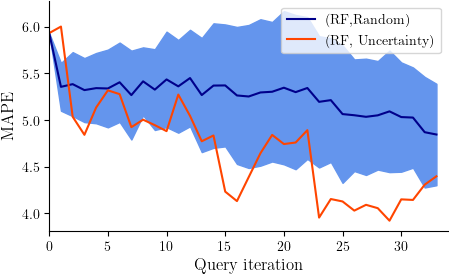

In [20]:
plot_scores(
    scores["FEV1_random"], scores["FEV1_std_dev"], "RF Sampling", "FEV1"
)

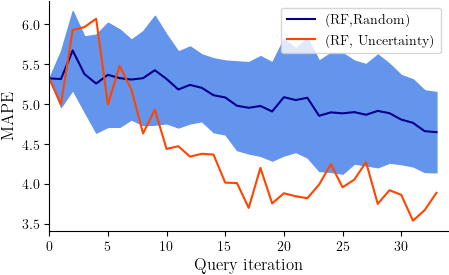

In [21]:
plot_scores(
    scores["FVC_random"], scores["FVC_std_dev"], "RF Sampling", "FVC"
)